In [23]:
from train import train_vqvae, DEVICE, train_pixel_cnn, test_pixel_cnn
from predict import generate_samples
from modules.vqvae import VQVAE
from modules.pixelcnn import PixelCNN
from dataset import train_dl, test_dl, batch_size, test_set, PixelCNNData
from torch.utils.data import DataLoader
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import tqdm

def show(img):
    """
    Plotting func
    """
    np_img = img.numpy()
    fig = plt.imshow(np.transpose(np_img, (1, 2, 0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [24]:
model = VQVAE(latent_dim=128, res_h_dim=32, num_embeddings=512, embedding_dim=64, beta=0.25)
model.to(DEVICE)
EPOCHS = 2

optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [23]:
training_reconstruction_loss = []
for i in range(EPOCHS):
    print(f"=======================EPOCH = {i + 1}======================")
    loss = train_vqvae(dl=train_dl, model=model, optim=optim)
    training_reconstruction_loss.append(loss)
    print(f"Reconstruction loss: {loss}")

=======================EPOCH = 1======================
batch    0/354 	 |current loss: 0.807003
batch   25/354 	 |current loss: 0.532948
batch   50/354 	 |current loss: 0.308322
batch   75/354 	 |current loss: 0.336627
batch  100/354 	 |current loss: 0.248623
batch  125/354 	 |current loss: 0.203222
batch  150/354 	 |current loss: 0.121747
batch  175/354 	 |current loss: 0.166472
batch  200/354 	 |current loss: 0.176555
batch  225/354 	 |current loss: 0.138061
batch  250/354 	 |current loss: 0.189433
batch  275/354 	 |current loss: 0.237457
batch  300/354 	 |current loss: 0.125128
batch  325/354 	 |current loss: 0.108246
batch  350/354 	 |current loss: 0.150739
Reconstruction loss: 0.23556041077705425
=======================EPOCH = 2======================
batch    0/354 	 |current loss: 0.103885
batch   25/354 	 |current loss: 12.274344
batch   50/354 	 |current loss: 0.583294
batch   75/354 	 |current loss: 0.172976
batch  100/354 	 |current loss: 0.148386
batch  125/354 	 |current lo

In [29]:
# save the model
torch.save(model, './results/vqvae.pth')

In [25]:
# load model
model = torch.load('./results/vqvae.pth')
model = model.to(DEVICE)

In [26]:
test_real = next(iter(test_dl))  # load some from test dl
test_real = test_real[0]
test_real = test_real.to(DEVICE)
pre_conv = model.pre_quantization_conv(model.encoder(test_real))  # encoder, reshape
_, test_quantized, _, _ = model.vector_quantizer(pre_conv)
test_reconstructions = model.decoder(test_quantized)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


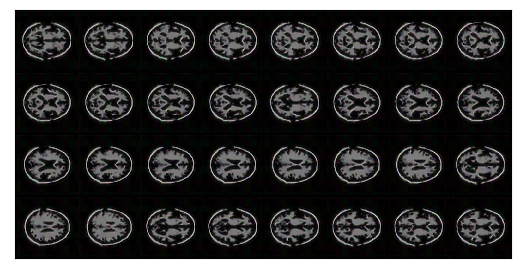

In [5]:
# show reconstructed images
show(torchvision.utils.make_grid(test_reconstructions.cpu()))

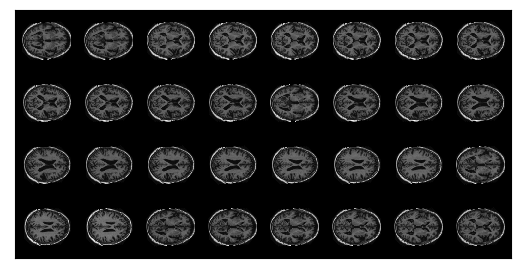

In [6]:
# show original images
show(torchvision.utils.make_grid(test_real.cpu()))

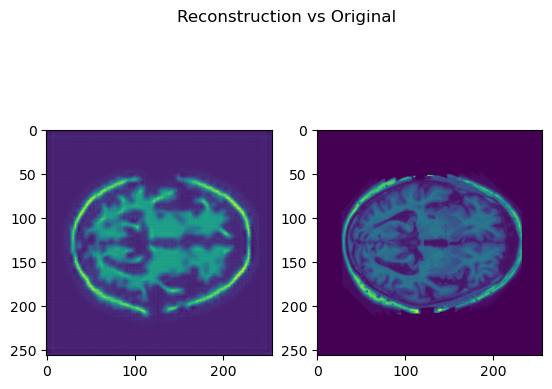

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Reconstruction vs Original')
ax1.imshow(test_reconstructions.cpu().detach().numpy()[0][1])
ax2.imshow(test_real.cpu().detach().numpy()[0][1])

torch.Size([1, 3, 256, 256])
tensor([113, 149, 430, 461])


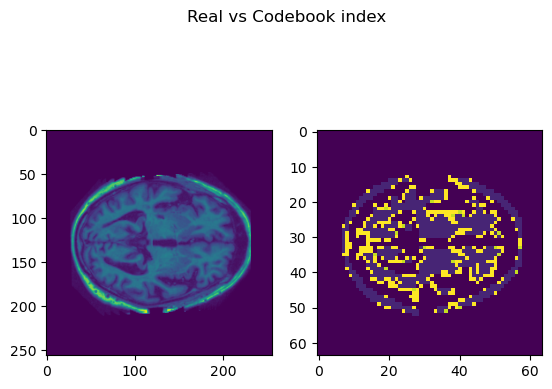

In [7]:
test_input = next(iter(test_dl))
test_input = test_input[0][0]
test_input = test_input.unsqueeze(0)
print(test_input.shape)
test_input = test_input.to(DEVICE)
test_encoded = model.encoder(test_input)
test_encoded = model.pre_quantization_conv(test_encoded)
_, test_encoded, encodings, indices = model.vector_quantizer(test_encoded)
decoded = model.decoder(test_encoded)
# Plot codebook index
plot_image = indices.view(64, 64)
print(torch.unique(indices.to('cpu')))
plot_image = plot_image.to('cpu')
detached_image = plot_image.detach().numpy()

test_input = test_input[0][0].cpu().detach().numpy()
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Real vs Codebook index')
ax1.imshow(test_input)
ax2.imshow(detached_image)

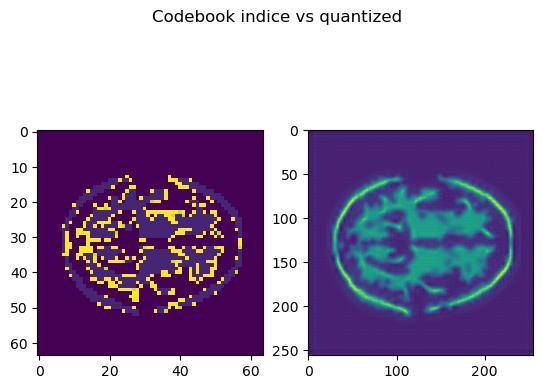

In [8]:
# Convert Codebook index to quantized
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Codebook indice vs quantized')
indices_quantized = model.vector_quantizer.get_quantized(indices)
decoded_quantized_indices = model.decoder(indices_quantized)
immi = decoded_quantized_indices[0]
immi = immi.to('cpu')
immi = immi.detach().numpy()
ax2.imshow(immi[1])
ax1.imshow(indices.cpu().view(64, 64).detach().numpy())

In [9]:
pixel_cnn = PixelCNN()
pixel_cnn = pixel_cnn.to(DEVICE)
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d
Skipping initialisation of MaskedGatedConv2d


In [10]:
pixel_cnn_train_ds = PixelCNNData(model=model, transforms=torchvision.transforms.ToTensor(), train=True)
pixel_cnn_train_dl = DataLoader(pixel_cnn_train_ds, batch_size=32)

pixel_cnn_test_ds = PixelCNNData(model=model, transforms=torchvision.transforms.ToTensor(), train=False)
pixel_cnn_test_dl = DataLoader(pixel_cnn_test_ds, batch_size=32)

In [12]:
BEST_LOSS = 999
LAST_SAVED = -1
cnn_epochs = 5
generated = []
for epoch in tqdm.tqdm(range(1, cnn_epochs)):
    print("\nEpoch {}:".format(epoch))
    train_pixel_cnn(pixel_cnn, pixel_cnn_train_dl, criterion, 512, opt)
    cur_loss = test_pixel_cnn(pixel_cnn, pixel_cnn_test_dl, criterion, 512)

    if cur_loss <= BEST_LOSS:
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch

        print("Saving model!")
        torch.save(model.state_dict(), 'results/{}_pixelcnn.pt'.format(pixel_cnn_train_dl))

    generated.append(generate_samples(pixel_cnn, 256))

  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1:


  0%|          | 0/4 [00:00<?, ?it/s]

before
torch.Size([32, 64, 64, -1])


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [13]:
f1 = generated[-1]

# Visualise generated code
generated_code_indice = f1[0][0]
generated_code_indice = generated_code_indice.to('cpu')
generated_code_indice = generated_code_indice.detach().numpy()
plt.imshow(generated_code_indice)

IndexError: list index out of range

In [14]:
generated_code_indice =  f1[0][0]
generated_code_indice = torch.flatten(generated_code_indice)

NameError: name 'f1' is not defined

In [15]:
unique_vals = [134, 418]

In [16]:
input_min = torch.min(generated_code_indice)
input_max = torch.max(generated_code_indice)

num_intervals = len(unique_vals) 
interval_size = (input_max - input_min)/num_intervals

for i in range(0, num_intervals):
  MIN = input_min + i*interval_size
  generated_code_indice[torch.logical_and(MIN<= generated_code_indice, generated_code_indice<=(MIN+interval_size))] = unique_vals[i]


NameError: name 'generated_code_indice' is not defined

In [17]:
torch.unique(generated_code_indice)

NameError: name 'generated_code_indice' is not defined

In [18]:
# Visualise generated codebook indice
ffqq = generated_code_indice
ffqq = ffqq.view(64,64)
ffqq = ffqq.to('cpu')
ffqq = ffqq.detach().numpy()
plt.imshow(ffqq)

NameError: name 'generated_code_indice' is not defined

In [19]:
generated_code_indice = generated_code_indice.long()
generated_output = model.vq.get_quantized(generated_code_indice)
generated_output = model.decoder(generated_output)
# Visualise
tt = generated_output[0][0]
tt = tt.to('cpu')
tt = tt.detach().numpy()
plt.imshow(tt)

NameError: name 'generated_code_indice' is not defined

In [41]:

from PIL import Image
from skimage.metrics import structural_similarity as ssim
import cv2
import os
from tqdm import tqdm

# Load test image for SSIM
images = os.listdir('./data/train/images/')
max_ssim = 0
max_ssim_image = None
accepted_ssim_count = 0
for image_name in tqdm(images):
  img_path = './data/train/images/' + image_name
  image = Image.open(img_path).convert('RGB')
  tfss = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor()
  ])
  image = tfss(image)
  image = image.unsqueeze(0)

  image1 = generated_output[0][0].to('cpu').detach().numpy()
  image2 = image[0][0].to('cpu').detach().numpy()
  ssim_val = ssim(image1, image2)
  if ssim_val > 0.6:
    accepted_ssim_count += 1
    if ssim_val > max_ssim:
      max_ssim = ssim_val
      max_ssim_image_name = image_name
      max_ssim_image = image2

print(f"SSIM was >0.60 against {accepted_ssim_count} images")
print(f"Max SSIM with {max_ssim_image_name} = {max_ssim}")
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Generated vs real (MAX SSIM)')
ax1.imshow(tt)
ax2.imshow(max_ssim_image)



  0%|          | 0/9664 [00:00<?, ?it/s]


NotImplementedError: The operator 'aten::_slow_conv2d_forward' is not current implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.